![스크린샷 2026-01-25 010514.png](<attachment:스크린샷 2026-01-25 010514.png>)
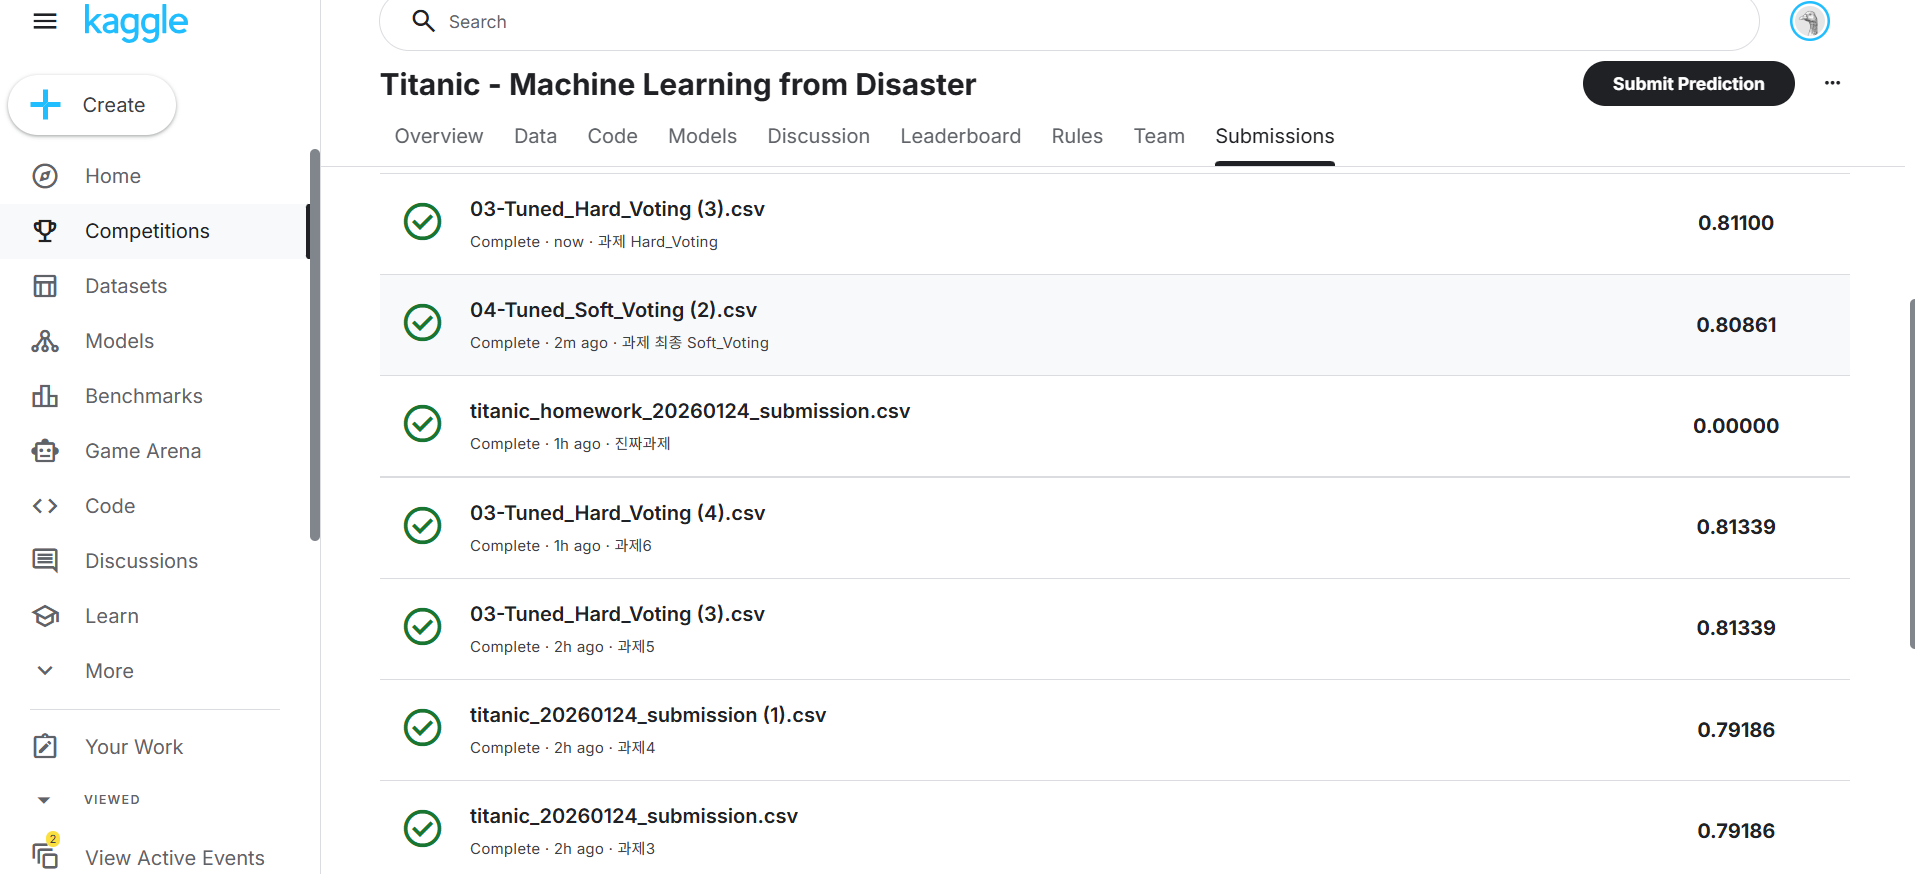

# Titanic: kaggle 점수 최대한 높게 받아보기


### 추가 및 개선된 사항
1. **티켓 빈도** : 동일한 티켓 번호를 공유하는 승객의 수를 카운트하여 데이터에 추가했습니다. 혼자 탄 승객인지, 일행(가족/친구)과 함께 탄 승객인지 파악하여 생존 패턴을 더 정밀하게 읽어냅니다.
2. **덱 추출** : 단순히 삭제하기 쉬운 Cabin(객실 번호) 정보에서 앞 글자만 추출하여 데이터에 추가했습니다. 이는 승객의 사회적 계급을 나타낼 수 있습니다. 배의 어느 위치(갑판 높이)에 머물렀는지가 구명보트 접근성에 미치는 영향을 모델에 학습시킵니다.
3. **더 정교하게 나누기** : 나이(Age)와 요금(Fare) 데이터를 최적의 구간으로 나누어 범주화했습니다. 미세한 수치 차이에서 오는 오차를 줄이고, 특정 연령대나 가격대별 생존 특징을 명확하게 부각합니다. 이는 각 특성의 분포를 더 정밀하게 읽어내고, 모델의 성능을 향상시킵니다.
4.  **앙상블 최적화** : 보팅 분류기(Voting Classifier)에서 각 개별 모델들이 미치는 가중치를 세밀하게 튜닝했습니다. 성능이 더 뛰어난 모델의 의견을 더 많이 반영하여 최종 예측의 신뢰도를 극대화했습니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Setting random seed for reproducibility
SEED = 42

## 1. Load Data

In [25]:
import os

ENV = 'local'
if ENV == 'colab':
    DATA_PATH = '/content/'
elif ENV == 'kaggle':
    DATA_PATH = '/kaggle/input/titanic/'
else:
    HOME = os.getcwd()
    DATA_PATH = os.path.join(HOME,'data','titanic')

DATA_PATH

'c:\\Users\\User\\Desktop\\github\\datascience\\scikit-learn\\data\\titanic'

In [18]:
trainCSV = os.path.join(DATA_PATH, 'train.csv')
testCSV = os.path.join(DATA_PATH, 'test.csv')

In [19]:
import os

# 1. 현재 설정된 경로 출력
print(f"현재 설정된 DATA_PATH: {DATA_PATH}")

# 2. 해당 경로에 진짜 파일이 있는지 확인
if os.path.exists(DATA_PATH):
    print(f"✅ 경로가 존재합니다. 내부 파일: {os.listdir(DATA_PATH)}")
else:
    print("❌ 경로가 존재하지 않습니다! DATA_PATH를 수정해야 합니다.")

현재 설정된 DATA_PATH: data/titanic/
✅ 경로가 존재합니다. 내부 파일: ['test.csv', 'train.csv']


In [20]:
# 환경에 따른 데이터 경로로 학습/테스트 데이터 읽어오기
train_df = pd.read_csv(trainCSV)
test_df = pd.read_csv(testCSV)

print(f'데이터 로드 완료 (경로: {DATA_PATH})')
print(train_df.shape, test_df.shape)

데이터 로드 완료 (경로: data/titanic/)
(891, 12) (418, 11)


## 2. Feature Engineering

In [5]:
# Family Survival (가족 생존 지표)
all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])
all_data['Family_Survival'] = 0.5

# 성(Last Name)과 요금(Fare)을 기준으로 그룹화
for _, grp_df in all_data.groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

# 티켓 번호로 그룹화(성이 다르더라도 함께 온 가족이나 일행을 찾아냄)
for _, grp_df in all_data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

print('Done!')

Done!


In [ ]:
# Deck 피처 추가
# Cabin(객실 번호) 컬럼을 그냥 삭제하는 대신, 거기서 Deck 정보를 추출합니다
all_data['Deck'] = all_data['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

# 희귀한 덱들을 묶거나 처리
# T 덱은 매우 드물기 때문에 보통 A 덱과 묶거나, M(결측치) 또는 A로 보냅니다. 여기서는 T를 A로 합치겠습니다.
all_data['Deck'] = all_data['Deck'].replace('T', 'A')
all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'Z') 
all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'Y')
all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'X')

# 덱을 Label 인코딩하기
all_data['Deck'] = LabelEncoder().fit_transform(all_data['Deck'])
print('Done!')

Done!


In [ ]:
# 3. 티켓빈도(Ticket Frequency) 피처 추가
all_data['Ticket_Frequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')
print('Done!')

Done!


In [ ]:
# Title, Age, Fare, Embarked

# 호칭 추출 및 정리 (Title)
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# Title Label 인코딩하기
all_data['Title'] = LabelEncoder().fit_transform(all_data['Title'])

# Age 결측치 채우기 및 구간 나누기
all_data['Age'] = all_data.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
all_data['AgeBin'] = pd.qcut(all_data['Age'], 5, labels=False)

# Fare 결측치 채우기 및 구간 나누기
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())
all_data['FareBin'] = pd.qcut(all_data['Fare'], 13, labels=False)

# 탑승항구 결측치 채우기 및 Label 인코딩
all_data['Embarked'] = all_data['Embarked'].fillna('S')
all_data['Embarked'] = LabelEncoder().fit_transform(all_data['Embarked'])

# 성별 Label 인코딩
all_data['Sex'] = LabelEncoder().fit_transform(all_data['Sex'])

# Family Size 피처 만들기
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
# Family Size 구간 나누기
all_data['FamilySize_Bin'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'FamilySize_Bin'] = 0 # 혼자
all_data.loc[(all_data['FamilySize'] > 1) & (all_data['FamilySize'] <= 4), 'FamilySize_Bin'] = 1 # 소규모 가족
all_data.loc[all_data['FamilySize'] > 4, 'FamilySize_Bin'] = 2 # 대규모 가족

print('Done!')

Done!


In [ ]:
# columns drop하기
drop_cols = ['Name', 'Ticket', 'Cabin', 'Last_Name', 'PassengerId', 'SibSp', 'Parch', 'FamilySize', 'Age', 'Fare']
all_data = all_data.drop(columns=drop_cols)

print(f"Final Columns: {all_data.columns.tolist()}")
all_data.head()

## 3. Modeling

In [13]:
train = all_data[:len(train_df)]
test = all_data[len(train_df):]
test.drop(columns=['Survived'], inplace=True)

X = train.drop(columns=['Survived'])
y = train['Survived'].astype(int)
X_test = test

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

print('Done!')

Done!


In [ ]:
# 베이스 모델 선정
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=6, min_samples_split=2, min_samples_leaf=2, oob_score=True, random_state=SEED)
clf_et = ExtraTreesClassifier(n_estimators=500, max_depth=6, min_samples_split=2, min_samples_leaf=2, bootstrap=True, oob_score=True, random_state=SEED)
clf_gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=4, random_state=SEED)
clf_svc = SVC(probability=True, kernel='rbf', gamma='scale', random_state=SEED)
clf_knn = KNeighborsClassifier(n_neighbors=12)
clf_xgb = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=SEED)

# Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('rf', clf_rf),
        ('et', clf_et),
        ('gb', clf_gb),
        ('svc', clf_svc),
        ('knn', clf_knn),
        ('xgb', clf_xgb)
    ],
    voting='soft',
    weights=[1, 1, 2, 2, 1, 2]
)

scores = cross_val_score(voting_clf, X, y, cv=5, scoring='accuracy')
print(f"Voting CV Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

voting_clf.fit(X, y)

Voting CV Score: 0.8485 (+/- 0.0196)


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('et', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.","[1, 1, ...]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2


## 4. Submission

In [15]:
predictions = voting_clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('titanic_20260124_submission.csv', index=False)
print("Submission saved to titanic_20260124_submission.csv")

Submission saved to titanic_20260124_submission.csv
